## Avaliação em holdouts - Amazon Kindle

Interactions in the 'Amazon Kindle' dataset are SOMEWHAT well distributed.
Several users are present during the whole considered period (2014):
<!-- * 37067 users of 190248 (19.484%) occurr in 80.0% or more months. -->
* 3385 users of 5849 (57.873%) occurr in 80.0% or more months.

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData, getBucketsHoldouts
from plot_utils import lineplot_recallxholdout, recall_heatmap
from dataset_evaluation_utils import *
from recommenders_implicit import ISGD, RAISGD, RSISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateHoldouts, EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout

from datetime import datetime
import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
## BWT FWT

ACC, BWT, e FWT - Lopez-Paz e Ranzato GEM

In [3]:
def avg_recall(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    return np.mean( np.diag(results_matrix) )

def compute_BWT(results_matrix): # Lopez-Paz e Ranzato GEM 2017
    BWT = []
    n_checkpoints = results_matrix.shape[0]
    for T in range(1, n_checkpoints): # 1 means holdout 2, 2 means 3, so on
        Rti = results_matrix.iloc[T, 0:T] # get models performances' on previous holdouts
        Rii = np.diag(results_matrix)[0:T] # get models performances' on their closest holdouts (diagonal)
        E = sum( Rti - Rii ) # future models performances' - performances' of models closest to holdouts (diagonal)
        BWT.append( E/T ) # store average BWT for model
    return BWT, np.mean( BWT ) # return BWT and average BWT for all models

def compute_FWT(results_matrix): # Díaz-Rodriguez et al. 2018
    upper_tri = results_matrix.to_numpy()[np.triu_indices(results_matrix.shape[0], k=1)]
    return np.mean(upper_tri)

___
# Amazon Kindle
Small subset, ratings only.  
https://nijianmo.github.io/amazon/index.html


In [4]:
# importa dataset 'books playlists'
data = pd.read_csv('output/amazonkindle_dump/2nd_sampled_amazon_kindle.csv')
dataset_name = 'Amazon_Kindle'
user_col = 'user_id'
item_col = 'item_id'

In [5]:
data.shape

(92955, 4)

In [6]:
data.head()

,user_id,item_id,timestamp,date
0,B00DMCV7K0,ADX9AIXY7C0I5,1389052800,2014-01-01
1,B00DMCV7K0,A75W6T9I2S8BA,1389052800,2014-01-01
2,B00DMCV7K0,AE4ED1Z5FVB8W,1389052800,2014-01-01
3,B00DMCV7K0,A2A5PRRD7IIVTC,1389052800,2014-01-01
4,B00DMCV7K0,AD0ZM53JBGU8C,1389052800,2014-01-01


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92955 entries, 0 to 92954
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    92955 non-null  object
 1   item_id    92955 non-null  object
 2   timestamp  92955 non-null  int64 
 3   date       92955 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


### Convert timestamp

In [8]:
%%time 
# 2.42s
data['date'] = data['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
# data.sort_values(by='timestamp', inplace=True)

CPU times: user 872 ms, sys: 3.61 ms, total: 876 ms
Wall time: 997 ms


In [9]:
data.head()

,user_id,item_id,timestamp,date
0,B00DMCV7K0,ADX9AIXY7C0I5,1389052800,2014-01-01
1,B00DMCV7K0,A75W6T9I2S8BA,1389052800,2014-01-01
2,B00DMCV7K0,AE4ED1Z5FVB8W,1389052800,2014-01-01
3,B00DMCV7K0,A2A5PRRD7IIVTC,1389052800,2014-01-01
4,B00DMCV7K0,AD0ZM53JBGU8C,1389052800,2014-01-01


CPU times: user 96.6 ms, sys: 4.31 ms, total: 101 ms
Wall time: 175 ms


Text(0.5, 1.0, 'interactions per month')

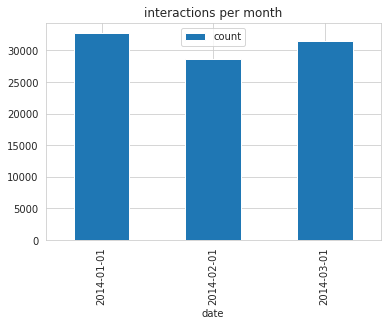

In [10]:
%%time
# 198ms
interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
interactions_per_month.name = 'count'
interactions_per_month=interactions_per_month.reset_index()
_ = interactions_per_month.copy()
_['date'] = _['date'].dt.date
_.groupby('date').sum().plot(kind='bar')
plt.title('interactions per month')

___
## Get intervals and Frequent users (threshold = 0.8)

time intervals

In [11]:
user_presence_df = pd.read_csv('output/amazonkindle_dump/2nd_sample_user_presence_df.csv')
user_month_interactions = pd.read_csv('output/amazonkindle_dump/2nd_sample_user_month_interactions.csv')
frequent_users_month = joblib.load('output/amazonkindle_dump/2nd_sample_frequent_users_month.joblib')

___
## Experiments using months

In [12]:
data.shape

(92955, 4)

In [14]:
%%time
# 29.7 s
buckets, holdouts = getBucketsHoldouts(
    data=data,
    user_col=user_col,
    item_col=item_col,
    frequent_users=frequent_users_month,
    interval_type='M',
    intervals=None, 
    cold_start_buckets=0)

Creating buckets. . .
Creating holdouts. . .
Cleaning holdouts. . .
common interactions between bucket 1 and all holdouts.
18
common interactions between bucket 2 and all holdouts.
19
common interactions between bucket 3 and all holdouts.
18
Converting to ImplicitData. . .
Done!
CPU times: user 29 s, sys: 73 ms, total: 29.1 s
Wall time: 29.4 s


Debugging buckets and holdouts - **only works if they're not converted to implicit data in get_buckets_and_holdouts.getBucketsHoldouts**

In [15]:
# # join buckets and holdouts, to check if they have any equal interactions (they should not)
# a = pd.concat( buckets ).set_index([user_col, item_col])
# b = pd.concat( holdouts )[[user_col, item_col]].set_index([user_col, item_col])
# a.join(b, how='inner').shape[0]

In [16]:
# # concatenate buckets and holdouts, to check if the result is equal to the original data (it should be equal)
# _  = pd.concat( [pd.concat( buckets ), pd.concat( holdouts )], ignore_index=True).sort_values(by=['timestamp', 'user_id','item_id']).reset_index(drop=True)
# _.equals(data.sort_values(by=['timestamp', 'user_id','item_id']).reset_index(drop=True))

In [17]:
# bucket_sizes = [b.shape[0] for b in buckets]
# holdout_sizes = [h.shape[0] for h in holdouts]
# bucket_sizes, holdout_sizes

In [19]:
joblib.dump(buckets, 'output/amazonkindle_dump/2nd_sample_buckets.joblib')
joblib.dump(holdouts, 'output/amazonkindle_dump/2nd_sample_holdouts.joblib')

['output/amazonkindle_dump/2nd_sample_holdouts.joblib']

### ISGD

In [20]:
buckets = joblib.load('output/amazonkindle_dump/2nd_sample_buckets.joblib')
holdouts = joblib.load('output/amazonkindle_dump/2nd_sample_holdouts.joblib')

Hyperparameters

In [21]:
# define hyperparameters (SAME AS LASTFM) ????
num_factors = 160
num_iter = 4
learn_rate = 0.5
regularization = 0.4
num_nodes = 8

In [22]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte. recebe listas
# stream = ImplicitData(data[user_col], data[item_col])
# O modelo deve ser iniciado com uma lista vazia
empty_stream = ImplicitData([], [])
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [23]:
%%time
# 23min 39s
# criamos instancia de EvaluateHoldouts para treinar o modelo e criar checkpoints
eval = EvaluateHoldouts(model=model, buckets=buckets, holdouts=holdouts)

bucket 0
bucket 1
bucket 2
CPU times: user 23min 34s, sys: 1.08 s, total: 23min 35s
Wall time: 23min 39s


In [24]:
%%time
# 1h 12min 53s
eval.EvaluateHoldouts(N_recommendations=20, exclude_known_items=True, default_user='none')

Holdout 0
B0015YEQNM user not seen
B0015YEQNM user not seen
B0013TPVJC user not seen
B00108KGZA user not seen
B0013TPVJC user not seen
B00108KGZA user not seen
B000YJ8554 user not seen
B000YJ8554 user not seen
B009DIU4EW user not seen
B009DIU4EW user not seen
B000W916C0 user not seen
B000W916C0 user not seen
B0016H97GO user not seen
B0016H97GO user not seen
recommendations not made for users in holdout 0 x bucket 0: 14
B0015YEQNM user not seen
B0015YEQNM user not seen
B00108KGZA user not seen
B00108KGZA user not seen
B000YJ8554 user not seen
B000YJ8554 user not seen
B009DIU4EW user not seen
B009DIU4EW user not seen
recommendations not made for users in holdout 0 x bucket 1: 8
B0015YEQNM user not seen
B0015YEQNM user not seen
B000YJ8554 user not seen
B000YJ8554 user not seen
recommendations not made for users in holdout 0 x bucket 2: 4
Holdout 1
B00108KGZA user not seen
B00108KGZA user not seen
B009DIU4EW user not seen
B0015YEQNM user not seen
B0015YEQNM user not seen
B0016H97GO user no

In [25]:
# joblib.dump(eval, 'output/amazonbooks_dump/2nd_sample_amazon_books ISGD eval.joblib')

In [26]:
rm = eval.results_matrix
df = pd.DataFrame(rm.T)
df.to_csv('output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD results.csv', index=False)

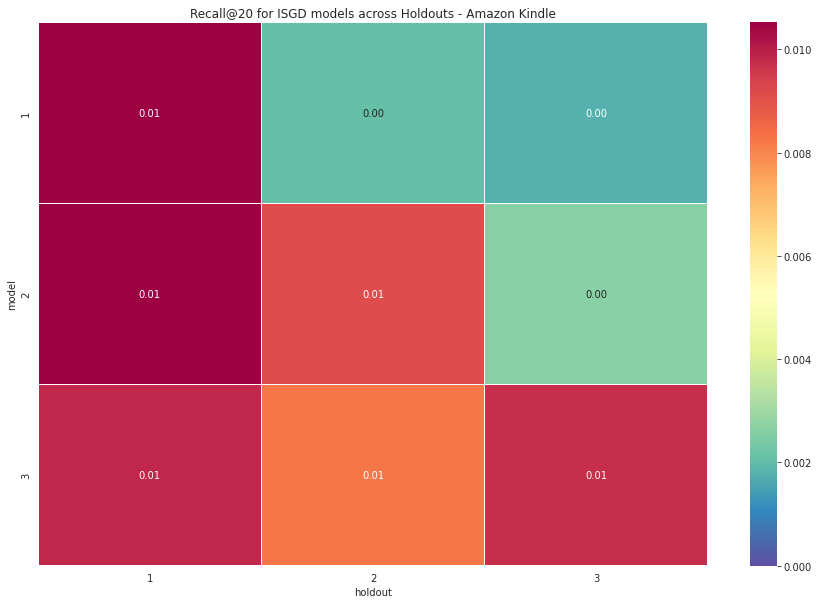

In [27]:
recall_heatmap(df,
    title='Recall@20 for ISGD models across Holdouts - Amazon Kindle',
    filepath='images/heatmaps/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD heatmap.png') #='images/heatmaps/palco_2010 month_bucket ISGD heatmap.png'

In [28]:
arecall = avg_recall(df)
arecall

0.009785763778206228

In [29]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([-2.072107841989343e-05, -0.0007902088308225919], -0.00040546495462124264)

In [30]:
FWT = compute_FWT(df)
FWT
# que itens que usuario utilizou no passado e deixou de consumir o sistema ainda pode recomendar

0.002161458667857289

In [31]:
BWT, meanBWT = compute_BWT(df)
BWT, meanBWT

([-2.072107841989343e-05, -0.0007902088308225919], -0.00040546495462124264)

In [32]:
joblib.dump(eval.IncrementalTraining_time_record, 'output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD training time.joblib')
joblib.dump(eval.EvaluateHoldouts_time_record, 'output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD eval time.joblib')

['output/amazonkindle_dump/2nd_sample_amazon_kindle month_bucket ISGD eval time.joblib']